In [80]:
#common imports:
import numpy as np
import pandas as pd
from datetime import datetime
import os
from itertools import permutations

#import for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors
import seaborn as sns
import matplotlib.pyplot as plt



#for Modelling/timeseries:
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter


from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf


from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_pacf
sns.set(rc={'figure.figsize':(20,15)})

#suppress pandas future warnings:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


    
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import ensemble
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [31]:
# load cleaned data time series:
df_time_m = pd.read_csv('timeseriesformodel.csv')

## Time series

For the vaccination progress we have daily observations points as daily vaccinations or people vaccinated per country.  Our target is to predict how the vaccination progress will continue in the next weeks. 

In [32]:
#set DatetimeIndex as index for our DataFrame:
df_daily = pd.read_csv('df2.csv', index_col=None)
#df_daily = df_daily.set_index('date')
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily.head(3)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines
0,Afghanistan,AFG,2021-02-23,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca
1,Afghanistan,AFG,2021-02-24,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca
2,Afghanistan,AFG,2021-02-25,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca


In [33]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   country                              7497 non-null   object        
 1   iso_code                             7497 non-null   object        
 2   date                                 7497 non-null   datetime64[ns]
 3   total_vaccinations                   4523 non-null   float64       
 4   people_vaccinated                    3983 non-null   float64       
 5   people_fully_vaccinated              7497 non-null   float64       
 6   daily_vaccinations                   7491 non-null   float64       
 7   total_vaccinations_per_hundred       4523 non-null   float64       
 8   people_vaccinated_per_hundred        3983 non-null   float64       
 9   people_fully_vaccinated_per_hundred  7497 non-null   float64       
 10  daily_vaccin

In [34]:
#df_daily.reset_index(inplace=True)

In [35]:
df_daily['day'] = df_daily['date'].dt.day
df_daily['month'] = df_daily['date'].dt.month
df_daily['year'] = df_daily['date'].dt.year
df_daily['weekday_name'] = df_daily['date'].dt.day_name()#day_of_week  
# Display a random sampling of 5 rows
df_daily.sample(5, random_state=0)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,day,month,year,weekday_name
4512,Mauritius,MUS,2021-02-02,NaN,NaN,0.0,58.0,NaN,NaN,0.00,46.0,Oxford/AstraZeneca,2,2,2021,Tuesday
2412,Finland,FIN,2021-02-09,227427.0,173558.0,53869.0,9065.0,4.10,3.13,0.97,1636.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",9,2,2021,Tuesday
4732,Mongolia,MNG,2021-03-11,48265.0,NaN,0.0,5009.0,1.47,NaN,0.00,1528.0,Oxford/AstraZeneca,11,3,2021,Thursday
4245,Luxembourg,LUX,2021-01-08,NaN,NaN,0.0,62.0,NaN,NaN,0.00,99.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",8,1,2021,Friday
5700,Qatar,QAT,2021-03-11,NaN,NaN,0.0,15381.0,NaN,NaN,0.00,5339.0,Pfizer/BioNTech,11,3,2021,Thursday


In [36]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [37]:
df_time = df_daily.copy()
df_time.set_index('date')
df_time = df_time[['date','country', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time.sample(20)

,date,country,daily_vaccinations,people_fully_vaccinated_per_hundred
4583,2021-02-18,Mexico,84658.0,0.00
5717,2020-12-31,Romania,2331.0,0.00
1221,2020-12-27,Canada,5649.0,0.00
3376,2021-03-18,Iran,3806.0,0.00
6876,2021-02-13,Switzerland,16941.0,0.00
766,2021-02-28,Belarus,412.0,0.00
2825,2021-02-18,Greenland,77.0,0.00
5173,2021-01-01,Oman,1289.0,0.00
4992,2021-03-20,Netherlands,31212.0,0.00
2965,2021-03-06,Guyana,547.0,0.00


In [38]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

,ID
date,0
country,0
daily_vaccinations,6
people_fully_vaccinated_per_hundred,0


In [39]:
df_time.dropna(axis=0)

,date,country,daily_vaccinations,people_fully_vaccinated_per_hundred
0,2021-02-23,Afghanistan,1367.0,0.0
1,2021-02-24,Afghanistan,1367.0,0.0
2,2021-02-25,Afghanistan,1367.0,0.0
3,2021-02-26,Afghanistan,1367.0,0.0
4,2021-02-27,Afghanistan,1367.0,0.0
...,...,...,...,...
7492,2021-03-20,Zimbabwe,836.0,0.0
7493,2021-03-21,Zimbabwe,910.0,0.0
7494,2021-03-22,Zimbabwe,805.0,0.0
7495,2021-03-23,Zimbabwe,655.0,0.0


In [40]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

,ID
date,0
country,0
daily_vaccinations,6
people_fully_vaccinated_per_hundred,0


In [41]:
df_time.isnull().any()

date                                   False
country                                False
daily_vaccinations                      True
people_fully_vaccinated_per_hundred    False
dtype: bool

In [42]:
df_time.dropna(inplace = True)

In [43]:
#check for missing values in %
round(100*(df_time.isnull().sum()/len(df_time.index)),0)

date                                   0.0
country                                0.0
daily_vaccinations                     0.0
people_fully_vaccinated_per_hundred    0.0
dtype: float64

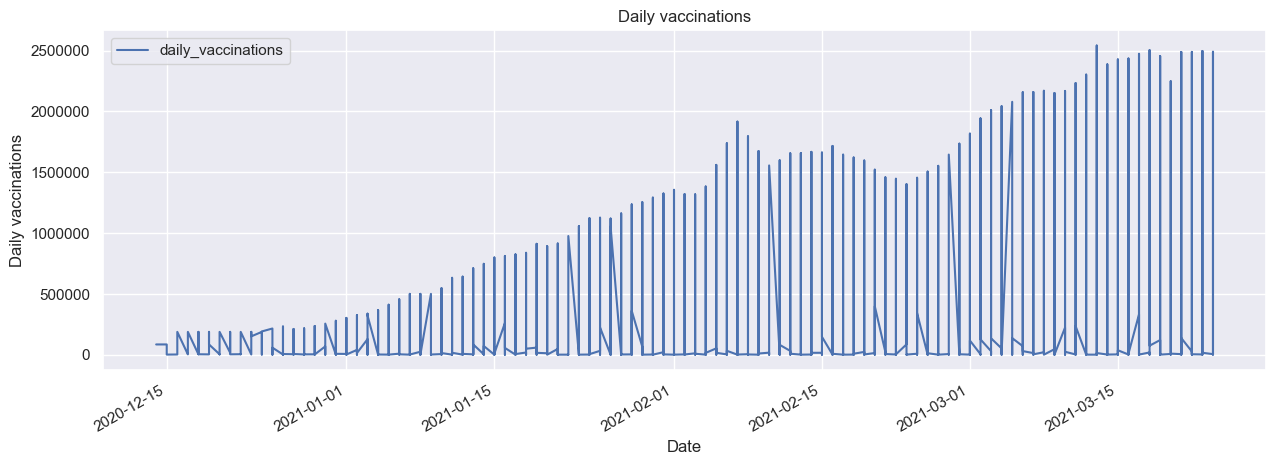

In [44]:
# plot the time series for daily vaccinations:
df_time1= df_time[['date','daily_vaccinations']]
df_time1.set_index('date', inplace=True)
ax1 = df_time1.plot()
# Add title and axis names

ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Daily vaccinations')
plt.xlabel('Date')
plt.ylabel('Daily vaccinations')

plt.show()

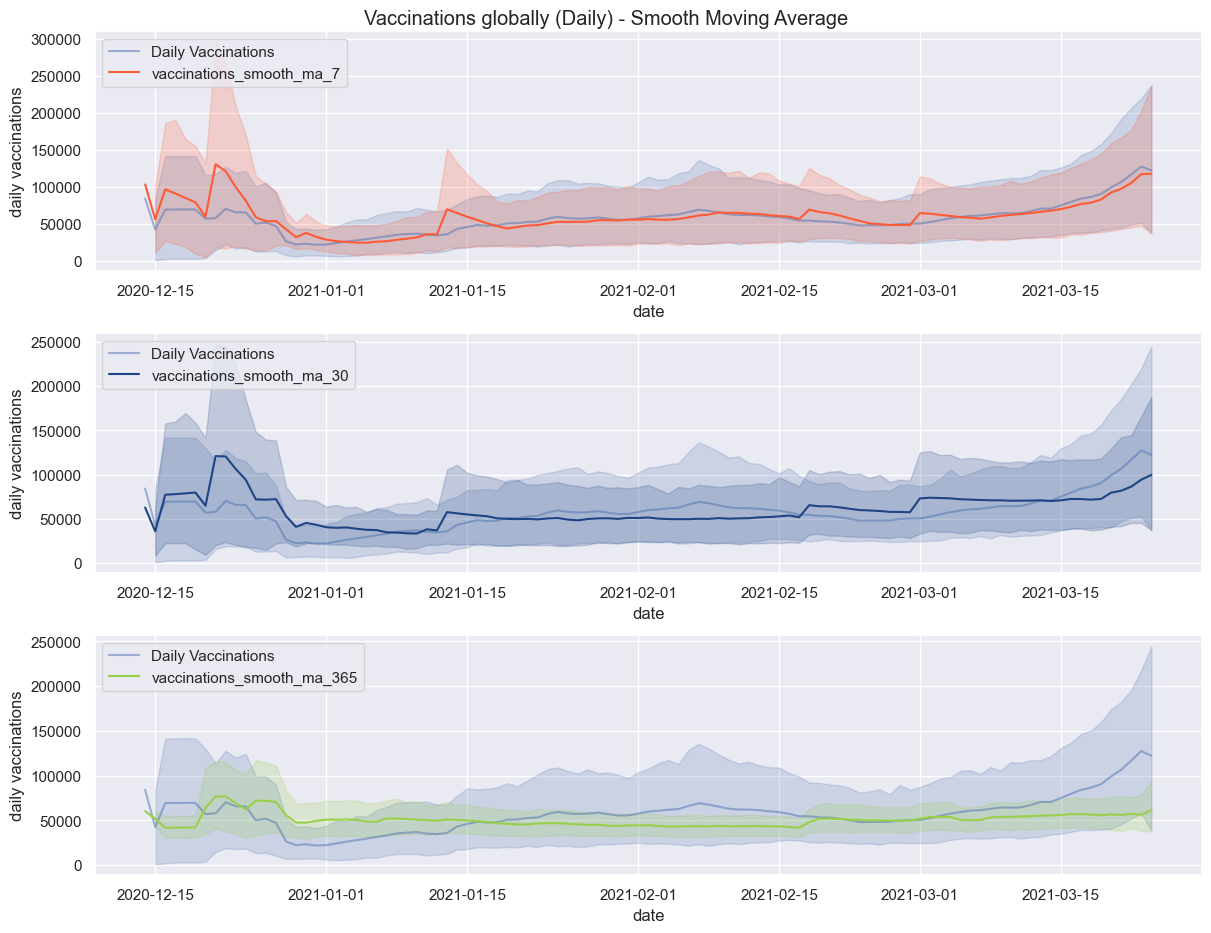

In [45]:
# Plot moving average of different length (week, month, year)
ma = [7, 30, 365]

smooth_daily_data_df = df_time1 \
    .reset_index() \
    .assign(date = lambda x: x['date'].transform(pd.to_datetime))

# Smooth and plot
fig, ax = plt.subplots(3, 1, figsize=(12, 9), constrained_layout=True)

for i, m in enumerate(ma):

    smooth_daily_data_df[f'vaccinations_smooth_ma_{m}'] = smooth_daily_data_df['daily_vaccinations'].rolling(window=m).mean()

    sns.lineplot(x='date', y='daily_vaccinations', label='Daily Vaccinations', data=smooth_daily_data_df, alpha=0.5, ax=ax[i])
    sns.lineplot(x='date', y=f'vaccinations_smooth_ma_{m}', label=f'vaccinations_smooth_ma_{m}', data=smooth_daily_data_df, color=sns_c[i + 1], ax=ax[i])
    ax[i].legend(loc='upper left')
    ax[i].set(title='', ylabel=r'daily vaccinations');

plt.suptitle('Vaccinations globally (Daily) - Smooth Moving Average', y=1.02);

First we decompose and plot our data to get an overview over the observed data, the trend, seasonality and residuals.

Trend: Increase and decrease in the value of the data. It can further be divided into global and local trends.

Seasonality: Repetitive pattern of fixed frequency that is visible in the data.

Noise/Resiudals: Random data that can be obtained after extracting the trend and seasonal component.

/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:30: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(bottom=0.2)


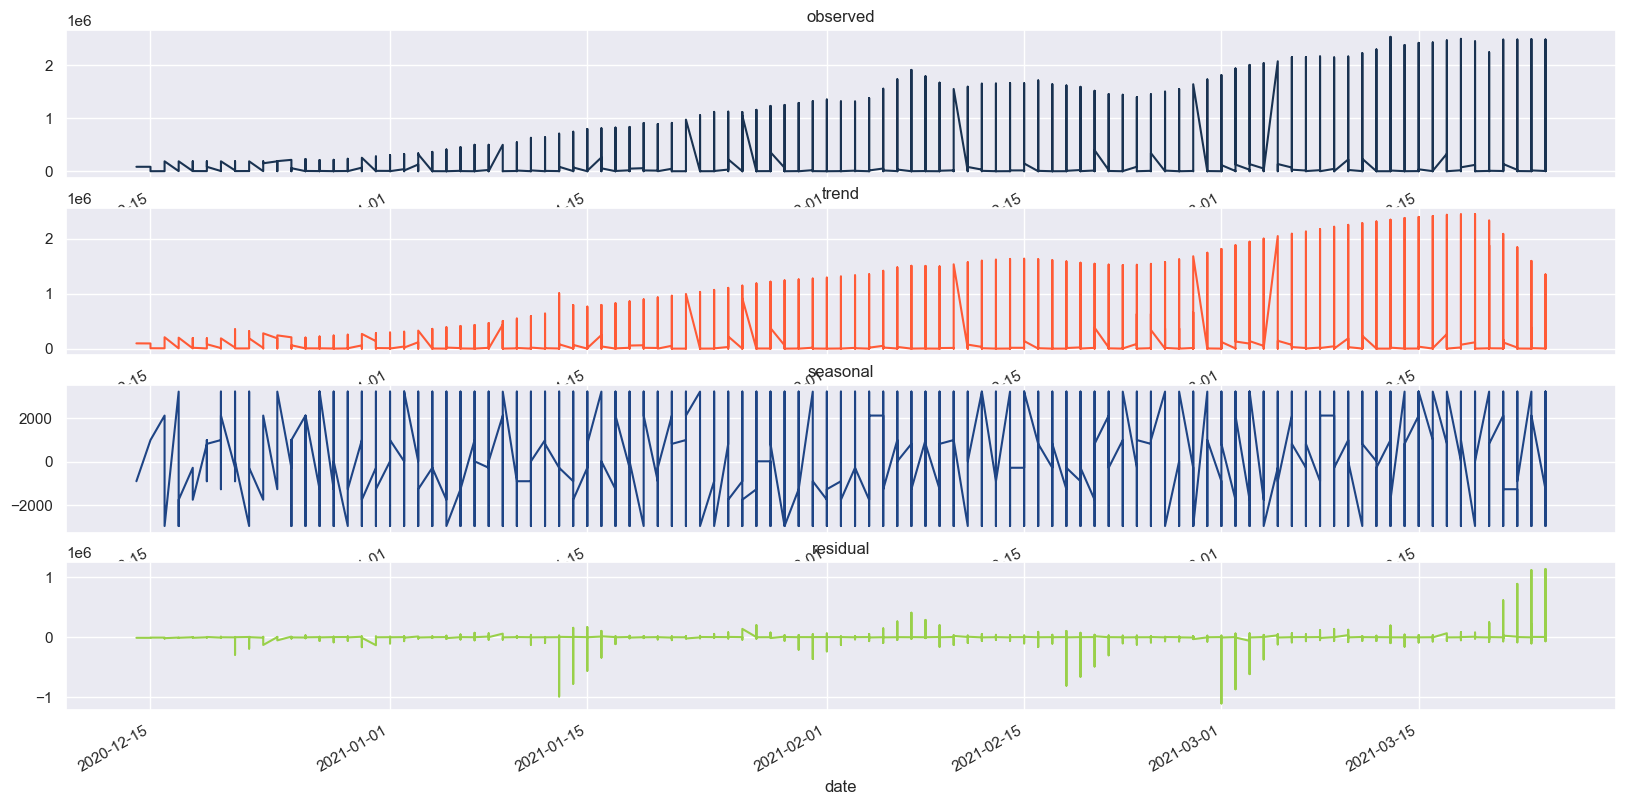

In [46]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time1['daily_vaccinations'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

xxx

## Check for Stationarity

Stationarity: A time series is stationary if its statistical properties (e.g. mean, variance, etc.) are the same throughout the series, independently of the point in time where you observe it. There are no long-term predictable patterns such as trend or seasonality. Plots will show a roughly horizontal trend with constant variance.

noch umschreiben:

In order to check for stationarity we will apply three different methods. First, we will calculate and plot the rolling mean and rolling standard deviation. It they show an upward or downward trend or vary over time, then it is highly likely that our time series is non-stationary. Furthermore, we will use the ADF (Augmented Dickey-Fuller) and the KPSS (Kwiatkowski-Phillips-Schmidt-Shintests) tests. We have to be careful when interpreting the results: the null-hypothesis of the ADF test is that the time series is non-stationary whereas the KPSS test assumes that it is stationary.

Data United States

In [48]:
#check for stationarity for country data:
df_time_us = df_time[df_time.country == 'United States']
df_time_us

,date,country,daily_vaccinations,people_fully_vaccinated_per_hundred
7313,2020-12-21,United States,57909.0,0.00
7314,2020-12-22,United States,127432.0,0.00
7315,2020-12-23,United States,150606.0,0.00
7316,2020-12-24,United States,191001.0,0.00
7317,2020-12-25,United States,215238.0,0.00
...,...,...,...,...
7402,2021-03-20,United States,2248285.0,12.87
7403,2021-03-21,United States,2488734.0,13.20
7404,2021-03-22,United States,2489697.0,13.43
7405,2021-03-23,United States,2497025.0,13.61


In [49]:
#check for missing values in %
round(100*(df_time_us.isnull().sum()/len(df_time_us.index)),0)

date                                   0.0
country                                0.0
daily_vaccinations                     0.0
people_fully_vaccinated_per_hundred    0.0
dtype: float64

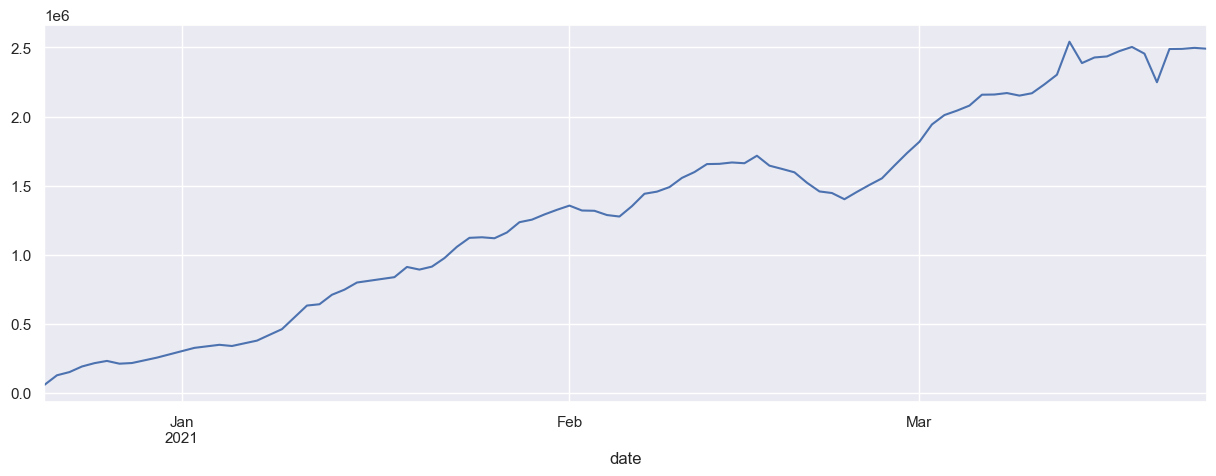

In [50]:
df_time_us.set_index('date', inplace=True)
df_time_us["daily_vaccinations"].plot();

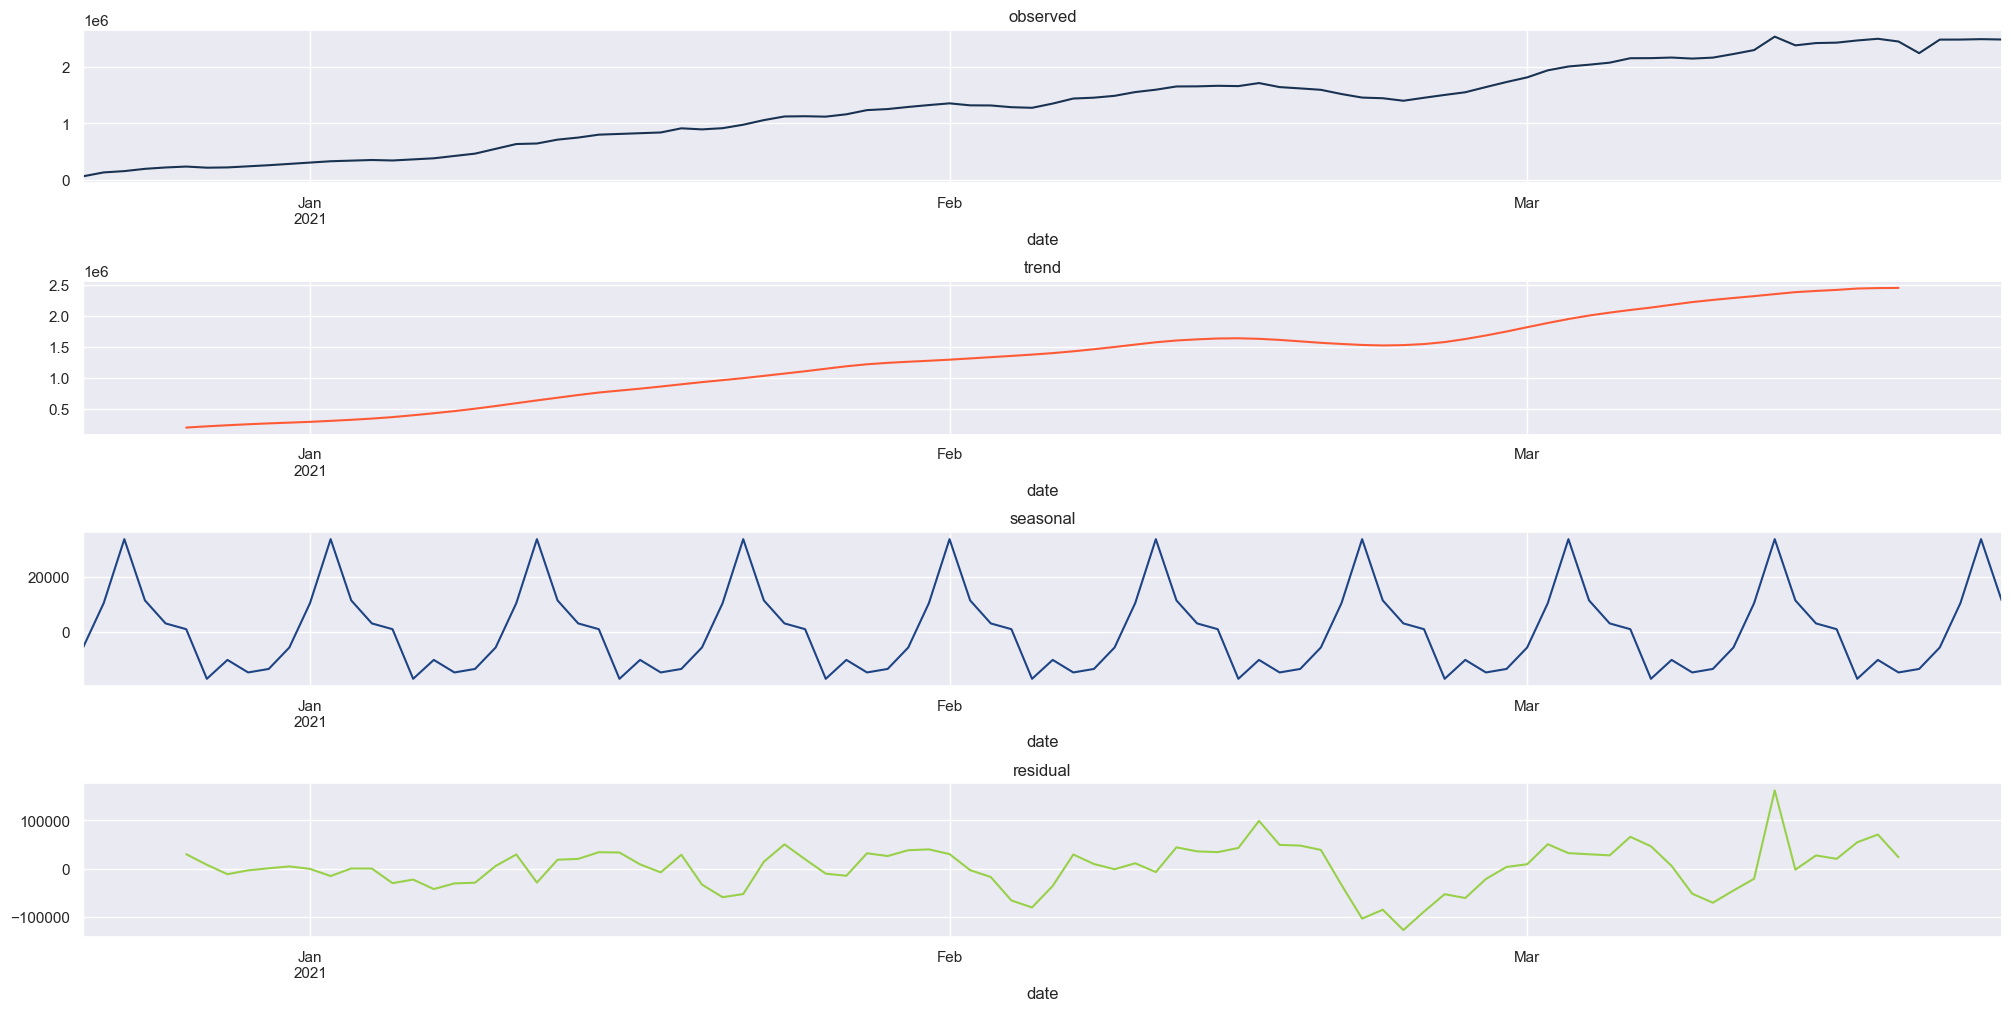

In [51]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time_us['daily_vaccinations'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

The daily vaccinations for the United States have a clear increasing trend and a weekly seasonality. 

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -0.520049
p-value: 0.888044
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.815044
p-value: 0.010000
----------------------------------------


/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


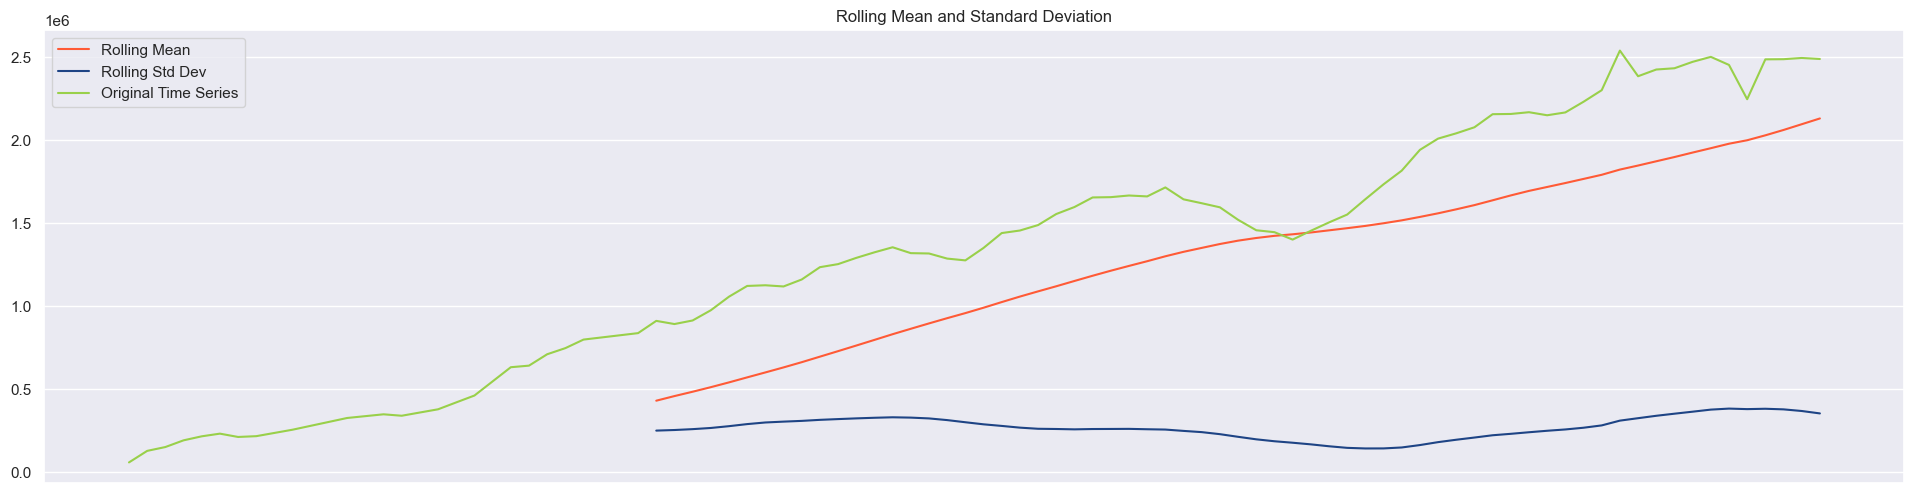

In [52]:
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time_us['daily_vaccinations'])

The p-value of the ADF test is > 0.5 which tells us that we cannot decline the null-hypothesis that the time series is non-stationary and the p-value for the KPSS test is below 0.05 which means we can reject this null-hypothesis that it is stationary. Both tests indicates that it is not stationary.

We need to de-trend the time series as it is non-stationary

In [61]:
# De-trending the time series
df_time_us['Dailyvac_Detrend'] = (df_time_us['daily_vaccinations'] - df_time_us['daily_vaccinations'].shift(7))

<ipython-input-61-68427a6f95fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_us['Dailyvac_Detrend'] = (df_time_us['daily_vaccinations'] - df_time_us['daily_vaccinations'].shift(7))


In [68]:
df_time_us['Dailyvac_Detrend']#.dropna().values

date
2020-12-21         NaN
2020-12-22         NaN
2020-12-23         NaN
2020-12-24         NaN
2020-12-25         NaN
                ...   
2021-03-20   -293312.0
2021-03-21    101802.0
2021-03-22     62267.0
2021-03-23     61988.0
2021-03-24     17127.0
Name: Dailyvac_Detrend, Length: 94, dtype: float64

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -3.338362
p-value: 0.013248
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.059166
p-value: 0.100000
----------------------------------------


/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


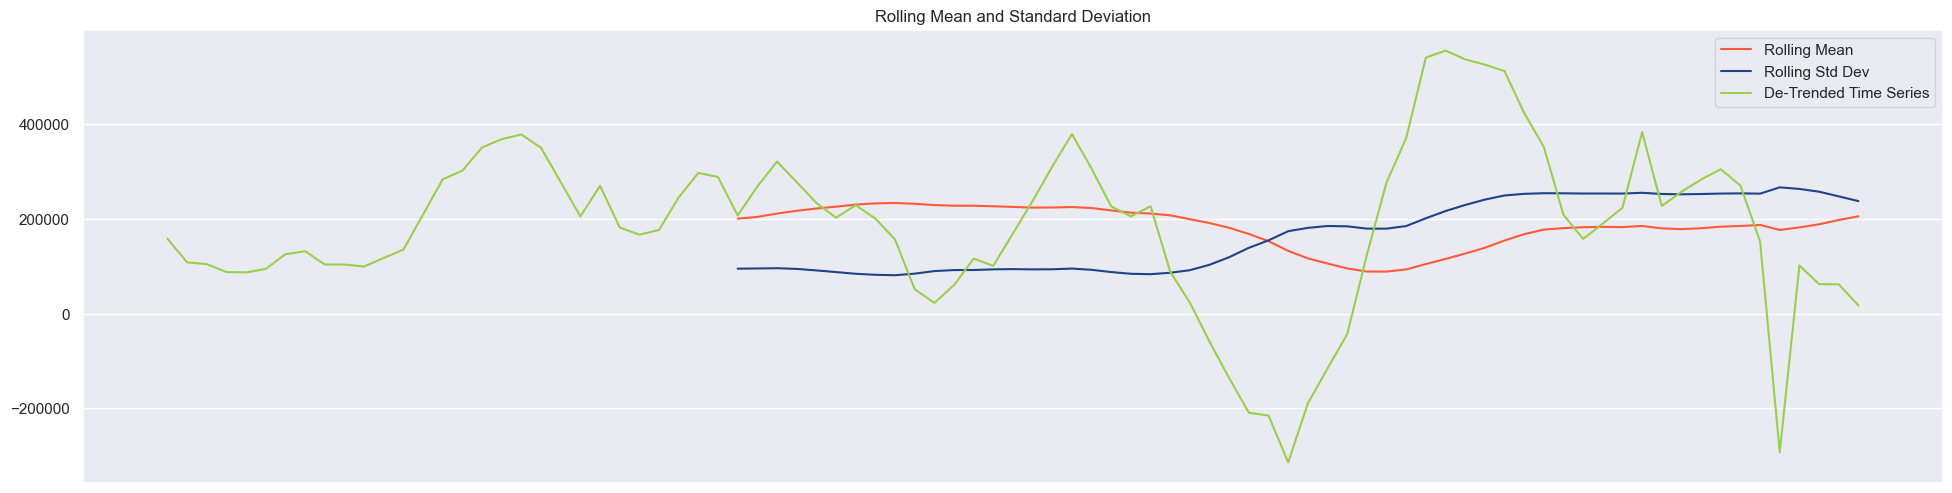

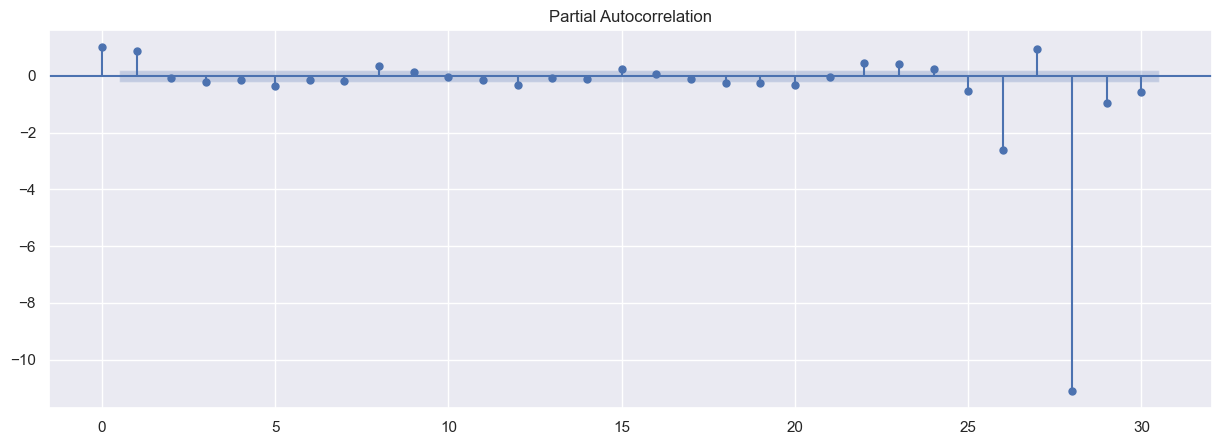

In [72]:
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='De-Trended Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time_us['Dailyvac_Detrend'].dropna())
                  
# Partial Autocorrelation Plot
pacf = plot_pacf(df_time_us['Dailyvac_Detrend'].dropna(), lags=30)

After de-trending the time series the AFD test as well as the KPSS test both indicate that our series is now stationary. Having a look at the partial autocorrelation plot suggests that correlation exists at certain lags.

## Split the Data

We will split our data and take the first part as our training set.

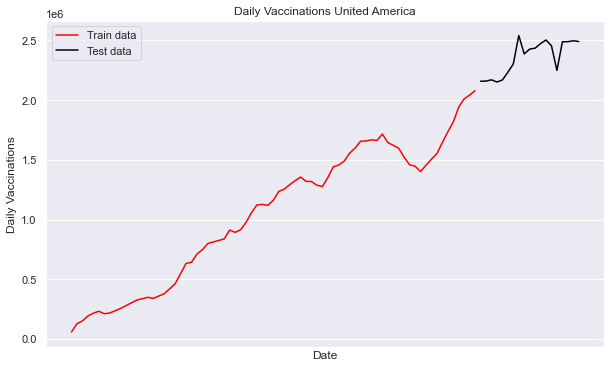

In [83]:
# Split data into train and test set
df_arima = df_time_us['daily_vaccinations']
train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.title('Daily Vaccinations United America')
plt.xlabel('Date')
plt.ylabel('Daily Vaccinations')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

### Auto-Regressive Integrated Moving Average (ARIMA)

ARIMA model is a combination of Auto-Regressive and Moving Average model along with the Integration of differencing. Auto-Regressive model determines the relationship between an observation and a certain number of lagged observations. The Integrated part is the differencing of the actual observations to make the time series stationary. Moving Average determines the relationship between an observation and residual error obtained by using a moving average model on the lagged observations.

* *Auto-Regressive (p)*: Number of lag observations in the model. Also called lag order.
* *Integrated (d)*: Number of times the actual observations are differenced for stationarity. Also called degree of differencing.
* *Moving Average (q)*: Size of moving average window. Also called the order of moving average.

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1747.338, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1760.031, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1751.903, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1747.655, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1758.067, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1751.653, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1749.861, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1749.937, Time=0.02 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1752.246, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0] intercept
Total fit time: 0.498 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   75
Model:

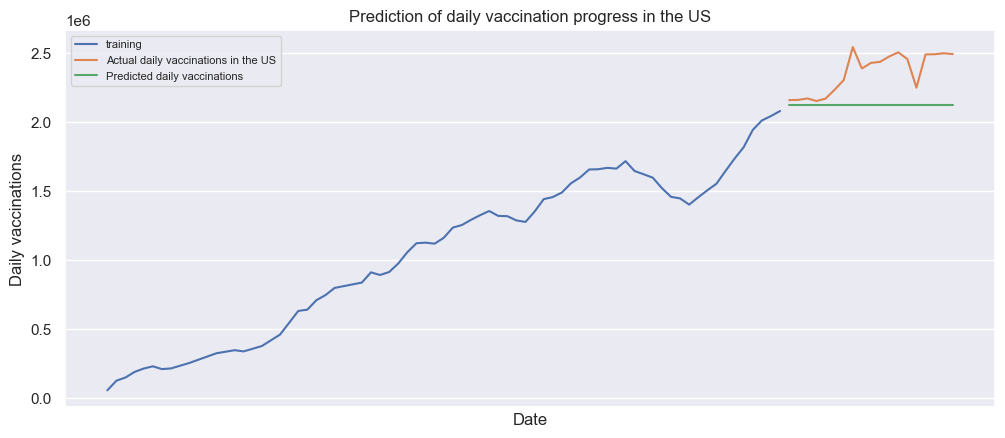

Auto-Arima RMSE :- 276256.807


In [76]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False
                      )

# Fit the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual daily vaccinations in the US')
plt.plot(fcv_series,label='Predicted daily vaccinations')
plt.title('Prediction of daily vaccination progress in the US')
plt.xlabel('Date')
plt.ylabel('Daily vaccinations')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

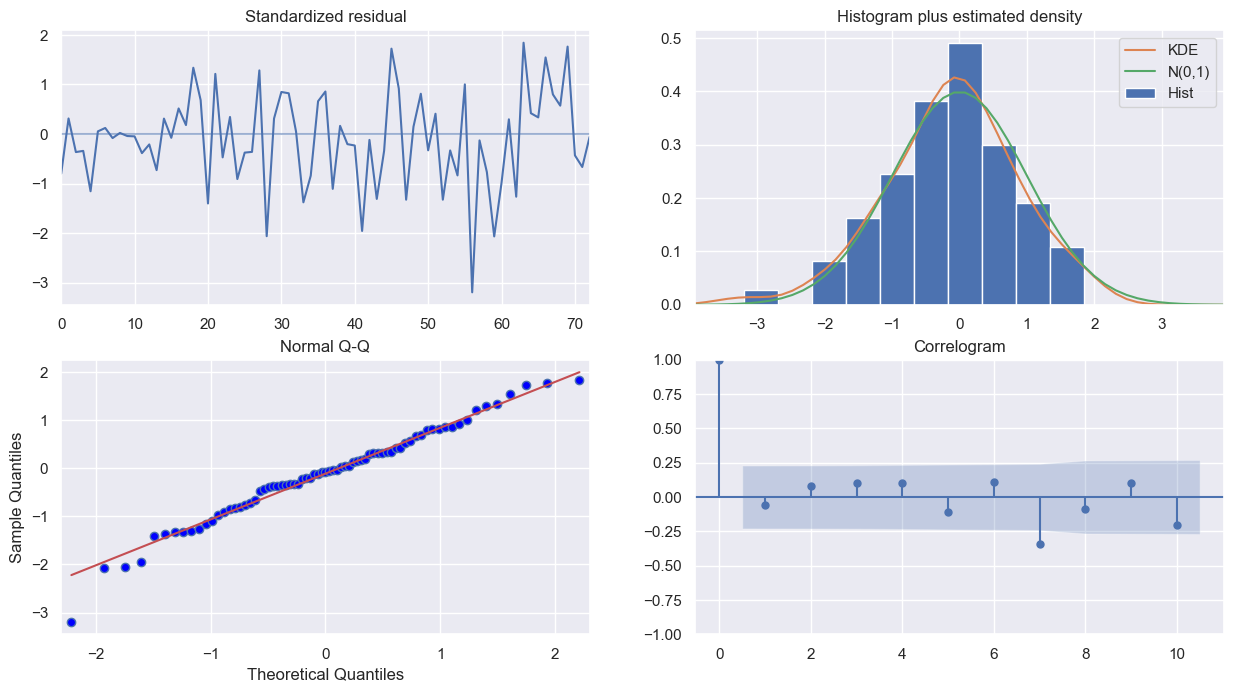

In [77]:
# Plotting diagnostics of the ARIMA model
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

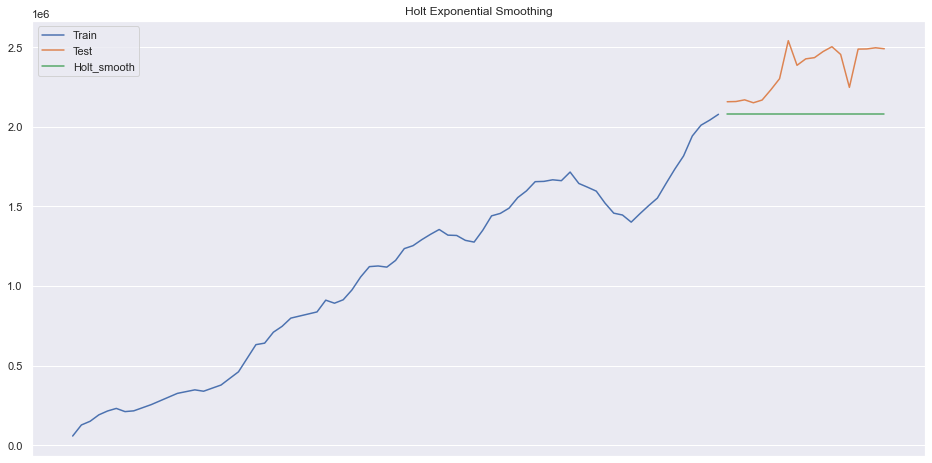

Holt’s Exponential Smoothing RMS :- 312111.348 & Smoothing Level :- 1.0 & Smoothing Slope :- 0.05


In [85]:
# Holt's Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)
Holt_smooth_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
    fit_Holt_smooth = ExponentialSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_smooth'] = fit_Holt_smooth.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_smooth)),3)
    Holt_smooth_df = Holt_smooth_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = Holt_smooth_df.loc[Holt_smooth_df['RMS'] == min(Holt_smooth_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_Holt_smooth = ExponentialSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_smooth'] = fit_Holt_smooth.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_smooth'], label='Holt_smooth')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_smooth))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

## Simple Exponential Smoothing

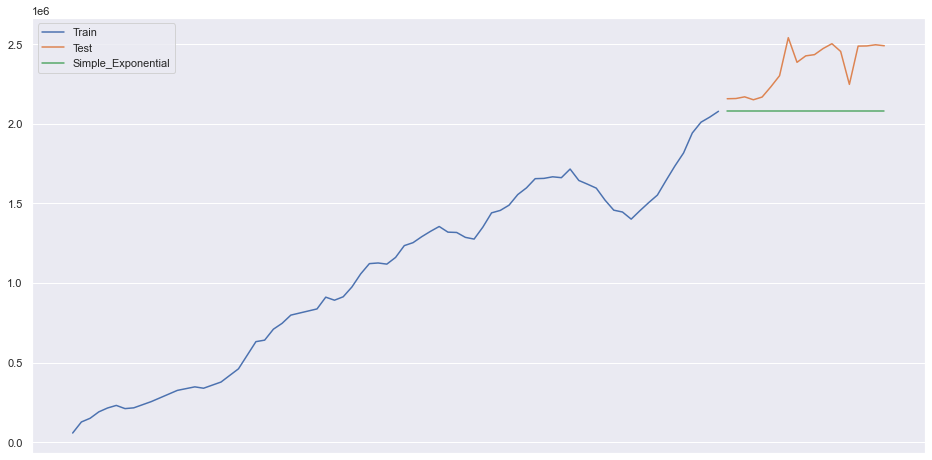

Simple Exponential Smoothing RMS :- 312111.348 & Smoothing Level :- 1.0


In [86]:
# Simple Exponential Smoothing Method

simple_exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
    fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
    pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
    simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = simple_exponential_df.loc[simple_exponential_df['RMS'] == min(simple_exponential_df['RMS']),['Smoothing Level']].values


# Use optimised values from the lists
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.xticks([])
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

## Evaluation of the Models

To evaluate the performance of the model, we will use Root Mean Squared Error (RMSE) and compare which model performed the best.

In [87]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

RMSE of all the methods
Auto-Arima:  276256.807
Simple Exponential Smoothing:  312111.348
Holt’s Exponential Smoothing:  312111.348


From the three models we trained the Auto-Arima reached the smallest RSME but all three models do not deliver a good prediction.

Future Work:
- work on better predictions

## De-trend the Time Series 

In [ ]:
# De-trending the time series
df_time_us['dayvacc_Detrend'] = (df_time_us['daily_vaccinations'] - df_time_us['daily_vaccinations'].shift(30))

In [ ]:
# Test for stationarity after de-trending 
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time_us['dayvacc_Detrend'].dropna())

# Partial Autocorrelation Plot
pacf = plot_pacf(df_time_us['dayvacc_Detrend'].dropna(), lags=30)

In [ ]:
# sum up all vaccinations values per day for getting a global value
df_time_index = df_time[['date', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time_index['date'] = pd.to_datetime(df_time_index.date)

df_time_index.set_index('date', inplace=True)
df_time_index.index.get_level_values('date').floor('D')
df_time_index = df_time_index.groupby('date').sum().reset_index()
df_time_index.to_csv('dates_aggregated.csv', encoding='utf-8', index=True)

In [ ]:
df_time_index

In [ ]:
df_time.to_csv('timeseriesformodel.csv', encoding='utf-8', index=False)

In [ ]:
#df1_corr.head()

In [ ]:
#df_time = df1_corr.copy()
df_time.set_index('date')
df_time = df_time[['date','country', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time.sample(20)

In [ ]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

In [ ]:
df_time.dropna(axis=0)

In [ ]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

In [ ]:
df_time.isnull().any()

In [ ]:
df_time.dropna(inplace = True)

In [ ]:
#check for missing values in %
round(100*(df_time.isnull().sum()/len(df_time.index)),0)

In [ ]:
#global daily vaccinations:
df_time.set_index('date', inplace=True)
df_time["daily_vaccinations"].plot();

In [ ]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time['daily_vaccinations'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='daily_vaccinations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

xxx

## Check for Stationarity

Stationarity: A time series is stationary if its statistical properties (e.g. mean, variance, etc.) are the same throughout the series, independently of the point in time where you observe it. There are no long-term predictable patterns such as trend or seasonality. Plots will show a roughly horizontal trend with constant variance.

noch umschreiben:

In order to check for stationarity we will apply three different methods. First, we will calculate and plot the rolling mean and rolling standard deviation. It they show an upward or downward trend or vary over time, then it is highly likely that our time series is non-stationary. Furthermore, we will use the ADF (Augmented Dickey-Fuller) and the KPSS (Kwiatkowski-Phillips-Schmidt-Shintests) tests. We have to be careful when interpreting the results: the null-hypothesis of the ADF test is that the time series is non-stationary whereas the KPSS test assumes that it is stationary.

In [ ]:
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time['daily_vaccinations'])

The rolling mean moves up and down over time as as the daily vaccinations vary. The p-value of the ADF test is 0 which tells us that we can decline the null-hypothesis that the time series is non-stationary and the p-value for the KPSS test is over 0.05 which means we cannot reject this null-hypothesis that it is stationary. Both tests indicates that it is stationary.

United States

In [ ]:
#check for stationarity for country data:
df_time_us = df_time[df_time.country == 'United States']
df_time_us

In [ ]:
#check for missing values in %
round(100*(df_time_us.isnull().sum()/len(df_time_us.index)),0)

In [ ]:
#plot the people fully vaccinated per hundred for the US:
df_time_us.set_index('date', inplace=True)
df_time_us["daily_vaccinations"].plot();

In [ ]:
trend_check = df_time_us[['daily_vaccinations']]
trend_check.rolling(365).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Days', fontsize=20);

In [ ]:
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time_us['daily_vaccinations'])

The p-value of the ADF test is > 0.5 which tells us that we cannot decline the null-hypothesis that the time series is non-stationary and the p-value for the KPSS test is below 0.05 which means we can reject this null-hypothesis that it is stationary. Both tests indicates that it is not stationary.

In [ ]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time_us['daily_vaccinations'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='daily_vaccinations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

In [ ]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time_us['people_fully_vaccinated_per_hundred'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='daily_vaccinations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

## De-trend the Time Series 

In [ ]:
# De-trending the time series
df_time_us['dayvacc_Detrend'] = (df_time_us['daily_vaccinations'] - df_time_us['daily_vaccinations'].shift(30))

In [ ]:
# Test for stationarity after de-trending 
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time_us['dayvacc_Detrend'].dropna())

# Partial Autocorrelation Plot
pacf = plot_pacf(df_time_us['dayvacc_Detrend'].dropna(), lags=30)

# Benchmark Forecasting

#### Naive Forecast/Persistence algorithm

As baseline method we use the persistence algorithm. It uses the value at the previous time step (t-1) to predict the expected outcome at the next time step (t+1).


In [ ]:
df_time_m.head()

In [ ]:
df_time_m.info()

In [ ]:
df_time_m['date']=df_time_m['date'].astype('datetime64[ns]')

#

In [ ]:
df_time_m['date']= pd.to_datetime(df_time_m['date'])
df_time_wo_detrend = df_time_m[['date','daily_vaccinations']]
df_time_wo_detrend.set_index('date', inplace = True)
df_time_wo_detrend.to_csv('df_time_wo_detrend.csv', encoding='utf-8', index=False)

In [ ]:
# Create lagged dataset
#dataframe = pd.concat([df_time_wo_detrend['daily_vaccinations'].shift(periods = 1)], axis =1)
#values = series.values
#dataframe = pd.concat([values.shift(1), values], axis=1)
#dataframe.columns = ['t-1', 't+1']
#print(dataframe.head(5))

In [ ]:
# Create lagged dataset
df_time_wo_detrend = df_time_m[['daily_vaccinations']]
df_lagged = df_time_wo_detrend.copy()
trailing_window_size = 1

for window in range(1, trailing_window_size + 1):
    shifted = df_time_wo_detrend.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in df_time_wo_detrend.columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis=1)
df_lagged = df_lagged.dropna()
df_lagged.head(10)

In [ ]:
# split into train and test sets
X = df_lagged.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    y_pred = model_persistence(x)
    predictions.append(y_pred)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

geht das überhaupt über alle Länder? Sind doch eigentlich eine Zeitreihe pro Land und damit einzeln zu betrachten, oder?

In [89]:
#Baseline model for United states data only:
baseline_us = df_time_m[df_time_m.country == 'United States']
baseline_us = baseline_us[['date', 'daily_vaccinations']]
baseline_us.head()


#plt.plot(baseline_us['daily_vaccinations'])
#plt.show();

,date,daily_vaccinations
7307,2020-12-21,57909.0
7308,2020-12-22,127432.0
7309,2020-12-23,150606.0
7310,2020-12-24,191001.0
7311,2020-12-25,215238.0


#### Define the Supervised Learning Problem

The first step is to load the dataset and create a lagged representation. That is, given the observation at t-1, predict the observation at t+1.

In [90]:
# Create lagged dataset
df_time_wo_detrend_us = baseline_us[['daily_vaccinations']]
df_lagged_us = df_time_wo_detrend_us.copy()
trailing_window_size = 1

for window in range(1, trailing_window_size + 1):
    shifted = df_time_wo_detrend_us.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in df_time_wo_detrend_us.columns]
    
    df_lagged_us = pd.concat((df_lagged_us, shifted), axis=1)
df_lagged_us = df_lagged_us.dropna()
df_lagged_us.head(10)

,daily_vaccinations,daily_vaccinations_lag1
7308,127432.0,57909.0
7309,150606.0,127432.0
7310,191001.0,150606.0
7311,215238.0,191001.0
7312,231396.0,215238.0
7313,211379.0,231396.0
7314,216147.0,211379.0
7315,235685.0,216147.0
7316,255223.0,235685.0
7317,278776.0,255223.0


Test MSE: 8246182421.094


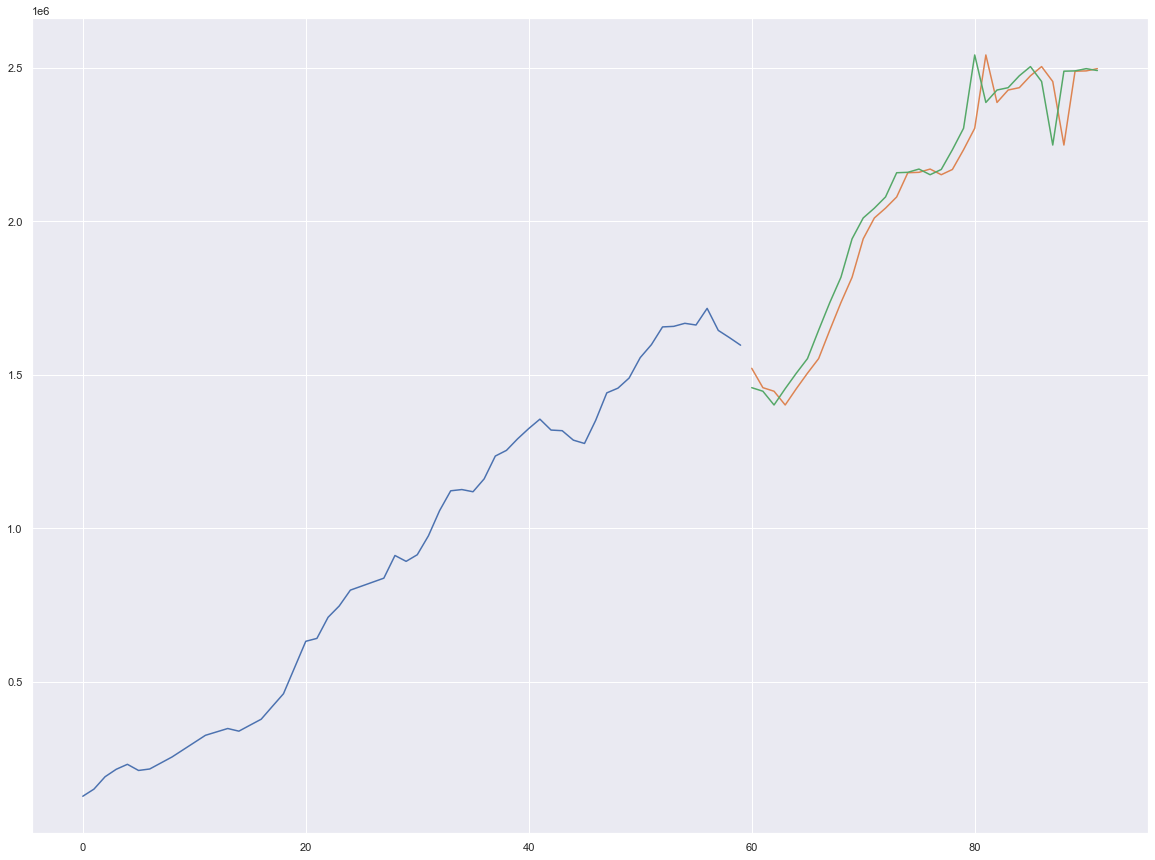

In [91]:
# split into train and test sets
X = df_lagged_us.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    y_pred = model_persistence(x)
    predictions.append(y_pred)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()
# label einfügen!

green line = test data
orange line = prediction

The plot shows the trainings dataset and the diverging predictions from the expected values from the test dataset.

It shows ???
(?The plot shows that the model is 1-step behind reality.?)



### Models for predicting vaccinations progress United States

In [ ]:
# Split data into train and test set
df_time_m_us = df_time_m[df_time_m.country == 'United States']
df_time_m_us = df_time_m_us[['daily_vaccinations']]
df_arima = df_time_m_us['daily_vaccinations']

train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Daily Vaccionation')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

## Simple Exponential Smoothing

In [ ]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

simple_exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
    fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
    pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
    simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = simple_exponential_df.loc[simple_exponential_df['RMS'] == min(simple_exponential_df['RMS']),['Smoothing Level']].values


# Use optimised values from the lists
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.xticks([])
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

## Holt's Exponential Smoothing

In [ ]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
    fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
    holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

## Auto-Regressive Integrated Moving Average (ARIMA)

In [ ]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False,
                      stationary = True,
                         n_jobs = -1
                      )#stationar = True ergänzt, n_jobs ergänzt mit -1 

# Fit the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual daily vaccinations')
plt.plot(fcv_series,label='Predicted daily vaccinations')
plt.title('Daily Vaccinations worldwide')
plt.xlabel('Date')
plt.ylabel('Daily Vaccinations')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

In [ ]:
# Plotting diagnostics of the ARIMA model
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

From the three models we trained the Holt's Exponential Smoothing reached the smallest RSME but all models are not really satisfying.

### Models for predicting vaccinations progress worldwide

In [ ]:
# Split data into train and test set
df_arima = df_time_m['daily_vaccinations']
train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Daily Vaccionation')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

## Simple Exponential Smoothing

In [ ]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

simple_exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
    fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
    pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
    simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = simple_exponential_df.loc[simple_exponential_df['RMS'] == min(simple_exponential_df['RMS']),['Smoothing Level']].values


# Use optimised values from the lists
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.xticks([])
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

## Holt's Exponential Smoothing

In [ ]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
    fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
    holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

## Auto-Regressive Integrated Moving Average (ARIMA)

In [ ]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False,
                      stationary = True,
                         n_jobs = -1
                      )#stationar = True ergänzt, n_jobs ergänzt mit -1 

# Fit the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual daily vaccinations')
plt.plot(fcv_series,label='Predicted daily vaccinations')
plt.title('Daily Vaccinations worldwide')
plt.xlabel('Date')
plt.ylabel('Daily Vaccinations')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

In [ ]:
# Plotting diagnostics of the ARIMA model
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

Evaluation of the models
to evaluate the performance of the model, we will use Root Mean Squared Error (RMSE) and compare which model performed the best.

In [ ]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

From the three models we trained the Simple Exponential Smoothing reached the smallest RSME. (Woran liegt das? Wir haben keinen Trend und keine seasonality und damit z.B. Holt's nicht geeignet?)